# Analysis of Bernie Sanders's ActBlue Donors

The code below analyzes campaign finance filings from ActBlue, a political action committee that processes the vast majority of contributions to Bernie Sanders's 2016 presidential campaign. For more details, read on.

In [1]:
import pandas as pd
import matplotlib as mpl
import us

In [2]:
%matplotlib inline

## Loading The Data

The code below loads ActBlue's `PRE-RUNOFF`, `POST-SPECIAL`, `PRE-PRIMARY`, `POST-RUN-OFF`, `MID-YEAR`, `YEAR-END`, `FEB MONTHLY`, and `MARCH MONTHLY` filings sent to the Federal Election Commission. These filings cover the entirety of the Sanders presidential campaign, which began on April 30, 2015.

The data include all "receipts" for this time period, and were downloaded from ProPublica's [FEC Itemizer](https://projects.propublica.org/itemizer/committee/C00401224/2016). Some rows in the files contained unmatched quotation marks (e.g., `"NOT EMPLOYED,`) in the `employer` field. BuzzFeed News fixed those rows by hand; because the cleaned-up files are large, you can download them [here](https://archive.org/details/actblue-fec-filings-april-2015-to-feb-2016).

*Note:* The Sanders campaign receives contributions through channels other than ActBlue, but ActBlue contributions account for approximately 82% of contributions to the campaign so far.

In [3]:
files = [
    "../data/actblue-filings/sa1034155.csv",
    "../data/actblue-filings/sa1047732.csv",
    "../data/actblue-filings/sa1051660.csv",
    "../data/actblue-filings/sa1056917.csv",
    "../data/actblue-filings/sa1024737.csv",
    "../data/actblue-filings/sa1033935.csv",
    "../data/actblue-filings/sa1034000.csv",
    "../data/actblue-filings/sa1034148.csv",
    "../data/actblue-filings/sa1056899.csv"
]

In [4]:
def parse_filing(path):
    dtype={
        "pac_name": str,
        "first_name": str,
        "last_name": str,
        "middle_name": str,
        "prefix": str,
        "suffix": str,
        "address_two": str,
        "zip": str,
        "employer": str,
        "occupation": str,
        "memo_code": str,
        "memo_text": str
    }
    return pd.read_csv(path, parse_dates=["date"], dtype=dtype)

In [5]:
all_act_blue = pd.concat([ parse_filing(filepath) for filepath in files ])

In [6]:
all_act_blue[
    all_act_blue["memo_text"].str.contains("BERNIE 2016", na=False)
]["memo_text"].value_counts()

Earmarked for BERNIE 2016 (C00577130)                                      4195727
Refund of contribution, initially earmarked for BERNIE 2016 (C00577130)       8451
Name: memo_text, dtype: int64

In [7]:
bernie = all_act_blue[
    all_act_blue["memo_text"] == "Earmarked for BERNIE 2016 (C00577130)"
].copy()

In [8]:
print("""Between April 30, 2015 and Feb. 29, 2016, the Sanders campaign received 
${0:,.0f} in contribtions via ActBlue.""".format(bernie["amount"].sum().round()))

Between April 30, 2015 and Feb. 29, 2016, the Sanders campaign received 
$112,718,405 in contribtions via ActBlue.


In [9]:
bernie_refunds = all_act_blue[
    all_act_blue["memo_text"] == "Refund of contribution, initially earmarked for BERNIE 2016 (C00577130)"
]

In [10]:
print("""Between April 30, 2015 and Feb. 29, 2016, ActBlue has refunded ${0:,.0f} of those contributions."""\
      .format(-bernie_refunds["amount"].sum().round()))

Between April 30, 2015 and Feb. 29, 2016, ActBlue has refunded $1,099,201 of those contributions.


This analysis ignores contribution refunds, for two reasons: (a) they're a small percentage of the overall contributions, and (b) this analysis is more concerned with the *act of giving* rather than the totals contributed. Furthermore, the way in which campaigns and committees refund contributions does not make clear *which* of a donor's contributions they are refunding.

In [11]:
"The data here encompasses ActBlue donations to Bernie 2016 between {0} and {1}."\
    .format(bernie.date.min(), bernie.date.max())

'The data here encompasses ActBlue donations to Bernie 2016 between 2015-04-30 00:00:00 and 2016-02-29 00:00:00.'

## Assigning Pseudo-IDs to Each Donor

FEC campaign filings do not assign any unique identifiers to donors. To be able to distinguish and track individual donors, the code below assigns each contribution a `donor_uid` based on the donor's first name, last name, and ZIP code. This approach could result an undercount of donors if, for instance, there are two people named John Smith in a same ZIP code — but should result in good approximations for the analyses below.

In [12]:
donor_uid_cols = ["first_name", "last_name", "zip"]
bernie["donor_uid"] = bernie[donor_uid_cols].fillna("").apply("|".join, axis=1)

## Counting The Number of Individual Donors

In [13]:
indivs = bernie\
    .sort_values("aggregate_amount", ascending=False)\
    .drop_duplicates(subset="donor_uid")

In [14]:
"Approximately {0:,} people have contributed to the Bernie Sanders campaign through ActBlue.".format(len(indivs))

'Approximately 1,509,688 people have contributed to the Bernie Sanders campaign through ActBlue.'

## Top ZIP Codes Donating To Bernie Sanders

*Note*: The Census Bureau reports population figures for geographies known as "[ZIP Code Tabulation Areas](https://www.census.gov/geo/reference/zctas.html)"; they don't overlap perfectly with ZIP codes, but they're as close as Census data gets.

In [15]:
zcta_pop = pd.read_csv("../data/zcta-population/ACS_14_5YR_B03002_with_ann.csv", skiprows=1, dtype={"Id2": str})

In [16]:
zcta_counties = pd.read_csv("../data/zcta-to-county.csv", dtype={"ZCTA5": str, "STATE": str})

Some ZIP codes cross state boundaries. The code below finds the main state, by population, associated with any given ZIP Code Tabulation Area.

In [17]:
zcta_states = zcta_counties.groupby([ "ZCTA5", "STATE" ])["ZPOPPCT"].sum()\
    .reset_index().sort_values("ZPOPPCT", ascending=False)\
    .groupby("ZCTA5")["STATE"]\
    .first().apply(lambda x: us.states.lookup(x).name)

In [18]:
zcta_states.head()

ZCTA5
00601    Puerto Rico
00602    Puerto Rico
00603    Puerto Rico
00606    Puerto Rico
00610    Puerto Rico
Name: STATE, dtype: object

In [19]:
zip_totals = pd.DataFrame({
    "contributors": indivs.groupby(["zip"]).size(),
    "state": zcta_states,
    "population": zcta_pop.set_index("Id2")["Estimate; Total:"],
}).dropna()

In [20]:
zip_totals.head()

,contributors,population,state
00601,1.0,18088.0,Puerto Rico
00602,6.0,40859.0,Puerto Rico
00603,9.0,53162.0,Puerto Rico
00610,6.0,28805.0,Puerto Rico
00612,8.0,66251.0,Puerto Rico


In [21]:
def calculate_per_capita(row):
    if row["population"] == 0: return None
    return round(row["contributors"] * 1000.0 / row["population"], 1)

In [22]:
zip_totals["donors_per_1000_people"] = zip_totals.apply(calculate_per_capita, axis=1)

Below is a list of the ZIP codes home to the largest numbers of donors to the Bernie 2016 campaign through ActBlue. The top ZIP code — 05401 — is located in Burlington, VT.

In [23]:
zip_totals.sort_values("contributors", ascending=False).head(10)

,contributors,population,state,donors_per_1000_people
05401,2829.0,28257.0,Vermont,100.1
94110,2357.0,71422.0,California,33.0
98103,2126.0,47559.0,Washington,44.7
10025,2115.0,97373.0,New York,21.7
11215,2071.0,70156.0,New York,29.5
60647,1970.0,87339.0,Illinois,22.6
14850,1796.0,65647.0,New York,27.4
97202,1743.0,39901.0,Oregon,43.7
94117,1718.0,42638.0,California,40.3
97214,1673.0,24673.0,Oregon,67.8


The next list shows the ZIP codes with the largest number of Sanders donors per capita — excluding ZIP codes in Sanders's home state of Vermont and excluding ZIP codes with fewer than 1,000 residents. The top ZIP code — 81131 — is located in Crestone, Colorado.

In [24]:
zip_totals[
    (zip_totals["population"] >= 1000) &
    (zip_totals["state"] != "Vermont")
].sort_values("donors_per_1000_people", ascending=False).head(20)

,contributors,population,state,donors_per_1000_people
81131,107.0,1173.0,Colorado,91.2
01054,145.0,1836.0,Massachusetts,79.0
95460,160.0,2338.0,California,68.4
20005,848.0,12497.0,District of Columbia,67.9
97214,1673.0,24673.0,Oregon,67.8
01072,98.0,1482.0,Massachusetts,66.1
95560,90.0,1374.0,California,65.5
98262,66.0,1079.0,Washington,61.2
94933,65.0,1069.0,California,60.8
94705,763.0,12790.0,California,59.7


In [25]:
zip_totals[
    (zip_totals["population"] >= 1000) &
    (zip_totals["state"] != "Vermont")
].sort_values("contributors", ascending=False).head(5)

,contributors,population,state,donors_per_1000_people
94110,2357.0,71422.0,California,33.0
98103,2126.0,47559.0,Washington,44.7
10025,2115.0,97373.0,New York,21.7
11215,2071.0,70156.0,New York,29.5
60647,1970.0,87339.0,Illinois,22.6


## Donors Who've Given Most Often

In [26]:
uid_grps = bernie.groupby("donor_uid")

In [27]:
indiv_totals = pd.DataFrame({
    "total_donations": uid_grps.size(),
    "total_amount": uid_grps["amount"].sum(),
    "city": uid_grps["city"].first(),
    "state": uid_grps["state"].first(),
    "employer": uid_grps["employer"].first(),
    "occupation": uid_grps["occupation"].first()
})

Based on the `donor_uid` groupings, 29 people have donated at least 100 times. You'll notice that some of the totals contribution amounts are greater than the FEC maximum allowed contribution of $2,700. The surplus has, or should soon be, refunded to those donors. But because we're interested in the *act of giving*, we've included all contributions here.

In [28]:
indiv_totals[
    indiv_totals["total_donations"] >= 100
].sort_values("total_donations", ascending=False)

,city,employer,occupation,state,total_amount,total_donations
donor_uid,,,,,,
CHRISTOPHER|FLESNER|72120,SHERWOOD,SELF EMPLOYED,PROGRAMMER,AR,1524.23,217
XITIJ|SHAH|75204,DALLAS,"CISCO SYSTEMS, INC.",SYSTEM ENGINEER,TX,2700.00,201
NICKOLAS|ZACHARIAS|66046,LAWRENCE,PREMIERE,CUSTOMER SERVICE,KS,2231.87,182
ANGELA|BAILEY|32771,SANFORD,NOT EMPLOYED,NOT EMPLOYED,FL,1221.41,174
CHI|SEXTON|77450,KATY,MEMORIAL HERMANN,HEALTHCARE ADMIN,TX,2491.87,150
MUSTAFA|FARIS|78752,AUSTIN,KEYE TV,AUDIO OPERATOR,TX,2187.66,149
PATRICIA|KELJIK|60056,MOUNT PROSPECT,NONE,NONE,IL,705.00,144
ROBERT|NUCHOW|87114,ALBUQUERQUE,PRESBYTERIAN HEART GROUP,FRONT DESK SPECIALIST,NM,2883.57,138
SUSAN|PHILLIPS|53527,COTTAGE GROVE,NONE,NOT EMPLOYED,WI,1758.66,133


In [29]:
indiv_totals[
    indiv_totals["total_donations"] >= 100
].state.value_counts()[:2]

CA    6
TX    5
Name: state, dtype: int64

## Additional Donor Characteristics

In [30]:
print("Approximately {0:.1f}% of Bernie Sanders donors have donated once."\
        .format(100 * len(indiv_totals[indiv_totals["total_donations"] == 1]) / float(len(indiv_totals))))

Approximately 53.4% of Bernie Sanders donors have donated once.


In [31]:
print("The average amount of a one-time donor to Bernie Sanders through ActBlue was ${0:.2f}."\
      .format(indiv_totals[indiv_totals["total_donations"] == 1]["total_amount"].mean()))

The average amount of a one-time donor to Bernie Sanders through ActBlue was $33.40.


In [32]:
print("Approximately {0:.1f}% of Bernie Sanders donors have given fewer than $200."\
      .format(100 * len(indiv_totals[indiv_totals["total_amount"] < 200]) / float(len(indiv_totals))))

Approximately 91.9% of Bernie Sanders donors have given fewer than $200.


In [33]:
print("The average amount of a donation to Bernie Sanders through ActBlue was ${0:.2f}."\
      .format(bernie.amount.mean()))

The average amount of a donation to Bernie Sanders through ActBlue was $26.87.


**Most Common Donation Amounts**

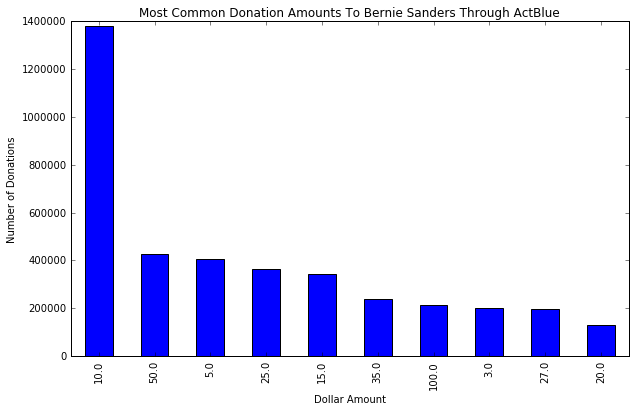

In [34]:
ax = bernie.amount.value_counts().head(10).plot(kind="bar", figsize=(10, 6))
ax.set_title("Most Common Donation Amounts To Bernie Sanders Through ActBlue")
ax.set_ylabel("Number of Donations")
ax.set_xlabel("Dollar Amount")
pass

## Total Contributions By Day

In [35]:
contributions_by_date = bernie.groupby("date")["amount"].sum()

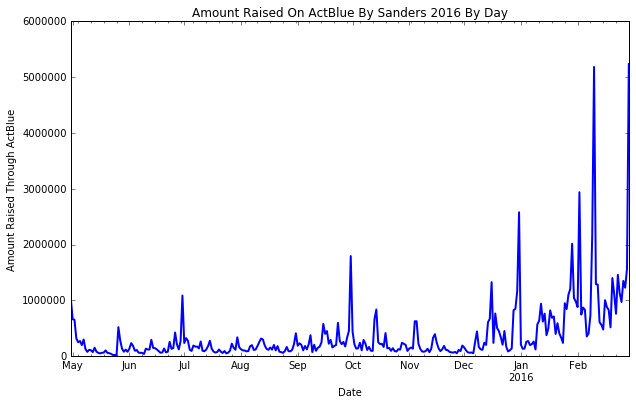

In [36]:
ax = contributions_by_date.plot(c="b", lw=2, figsize=(10, 6))
ax.set_xlabel("Date")
ax.set_ylabel("Amount Raised Through ActBlue")
ax.set_title("Amount Raised On ActBlue By Sanders 2016 By Day")
pass

Dates with the most total contributions:

In [37]:
contributions_by_date.sort_values(ascending=False).head(25).round(2)

date
2016-02-29    5234507.21
2016-02-10    5183185.22
2016-02-02    2938250.97
2015-12-31    2578982.93
2016-02-09    2179594.38
2016-01-29    2015977.79
2015-09-30    1793905.81
2016-02-28    1564612.35
2016-02-23    1457119.48
2016-02-20    1400264.61
2016-02-26    1349708.33
2015-12-16    1326367.29
2016-02-11    1291719.37
2016-02-12    1282912.12
2016-02-27    1227832.34
2016-01-28    1207215.43
2015-12-30    1168453.26
2016-02-24    1128312.36
2016-02-21    1113899.27
2016-01-27    1102945.53
2015-06-30    1087371.21
2016-01-30    1043235.70
2015-04-30    1032039.37
2016-02-16    1004262.26
2016-01-31     981349.64
Name: amount, dtype: float64

## New Donors By Day

The code below estimates the number of donors each day who *appear* (see caveat above about the lack of consistent, unique identifiers) to be giving to Sanders's presidential campaign for the first time.

In [38]:
new_donors_by_date = bernie.sort_values("date")\
    .groupby("donor_uid")["date"].first()\
    .value_counts()

In [39]:
new_donors_by_date.sort_index().head()

2015-04-30    23250
2015-05-01    14537
2015-05-02    15881
2015-05-03     7220
2015-05-04     5271
Name: date, dtype: int64

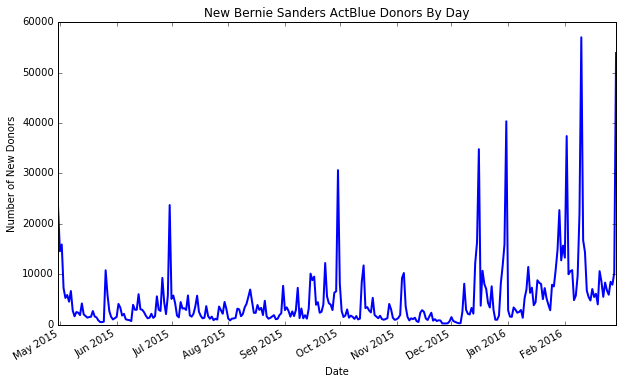

In [40]:
ax = new_donors_by_date.plot(color="b", lw=2, figsize=(10, 6))
ax.set_xlabel("Date")
ax.set_ylabel("Number of New Donors")
ax.set_title("New Bernie Sanders ActBlue Donors By Day")
pass

-------------------------

-------------------------